In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from prompt_toolkit.key_binding.bindings.named_commands import yank_nth_arg

In [30]:
def target_function(x1, x2, with_error=False):
    y = 2*x1**3 + 3*x1**2 - 5*x2 + 4 + x1*x2
    if with_error:
        y = y + np.random.random(x1.shape) * 0.1 - 0.05
    return y

In [31]:
# Подготовка данных
x1_min, x1_max = -2*np.pi, 2*np.pi
x2_min, x2_max = -2*np.pi, 2*np.pi
num_points = 50

x1 = np.linspace(x1_min, x1_max, num_points)
x2 = np.linspace(x2_min, x2_max, num_points)
X1, X2 = np.meshgrid(x1, x2)

Y_true = target_function(X1, X2, with_error=True)

x_data = np.column_stack((X1.ravel(), X2.ravel()))
y_data = Y_true.ravel().reshape(-1, 1)

In [32]:
# Архитектура сети
input_size = 2
hidden_size = 30
output_size = 1

In [33]:
# Инициализация весов
torch.manual_seed(42)
W1 = torch.randn(input_size, hidden_size, requires_grad=False) * 0.5
b1 = torch.zeros(1, hidden_size, requires_grad=False)
W2 = torch.randn(hidden_size, output_size, requires_grad=False) * 0.5
b2 = torch.zeros(1, output_size, requires_grad=False)

X = torch.tensor(x_data, dtype = torch.float32)
Y = torch.tensor(y_data, dtype = torch.float32)

In [34]:
# Функция активации
def activation(x):
    x = torch.clamp(x, -500, 500)
    return 1 / (1 + torch.exp(-x))

# Производная функции активации
def activation_derivative(x):
    return x * (1 - x)

In [35]:
# Нормализация
def norm(x):
    x_min = torch.min(x)
    x_max = torch.max(x)
    xn = (x - x_min)/(x_max - x_min)
    return xn, x_min, x_max

# Денормализация
def denorm(x, x_min, x_max):
    xd = x * (x_max - x_min) + x_min
    return xd

In [36]:
# Прямое распространение
def predict(X, W1, b1, W2, b2):
    z1 = torch.mm(X, W1) + b1
    a1 = activation(z1)
    z2 = torch.mm(a1, W2) + b2
    y_pred = z2
    return z1, a1, z2, y_pred

In [37]:
# Обратное распространение ошибки
def backward(X, Y, z1, a1, z2, y_pred, W2):
    m = X.size(0)
    dZ2 = y_pred - Y
    dW2 = torch.mm(a1.t(), dZ2) / m
    db2 = torch.sum(dZ2, dim = 0, keepdim=True) / m

    dA1 = torch.mm(dZ2, W2.t())
    dZ1 = dA1 * activation_derivative(a1)

    dW1 = torch.mm(X.t(), dZ1) / m
    db1 = torch.sum(dZ1, dim = 0, keepdim=True) / m

    return dW1, db1, dW2, db2


In [38]:
# Обновление весов
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    with torch.no_grad():
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
    return W1, b1, W2, b2

In [39]:
# Гиперпараметры сети
learning_rate = 0.25
epochs = 100000

In [40]:
# Вычисление функции потерь
def compute_loss(y_pred, Y):
    return torch.mean((y_pred - Y) ** 2)

In [41]:
# Обучение
def train(X, Y, W1, b1, W2, b2, learning_rate, epochs):
    losses = []
    for epoch in range(epochs):
        # Прямое распространение
        z1, a1, z2, y_pred = predict(X, W1, b1, W2, b2)

        # Вычисление функции потерь
        loss = compute_loss(y_pred, Y)
        losses.append(loss.item())

        # Обратное распространение
        dW1, db1, dW2, db2 = backward(X, Y, z1, a1, z2, y_pred, W2)

        # Обновление параметров
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        # Вывод информации об "образовательном процессе"
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: loss {loss.item():.6f}")

    return W1, b1, W2, b2, losses

Epoch 0: loss 0.888364
Epoch 1000: loss 0.001421
Epoch 2000: loss 0.000987
Epoch 3000: loss 0.000839
Epoch 4000: loss 0.000751
Epoch 5000: loss 0.000688
Epoch 6000: loss 0.000637
Epoch 7000: loss 0.000596
Epoch 8000: loss 0.000560
Epoch 9000: loss 0.000529
Epoch 10000: loss 0.000502
Epoch 11000: loss 0.000478
Epoch 12000: loss 0.000456
Epoch 13000: loss 0.000436
Epoch 14000: loss 0.000417
Epoch 15000: loss 0.000400
Epoch 16000: loss 0.000384
Epoch 17000: loss 0.000369
Epoch 18000: loss 0.000354
Epoch 19000: loss 0.000341


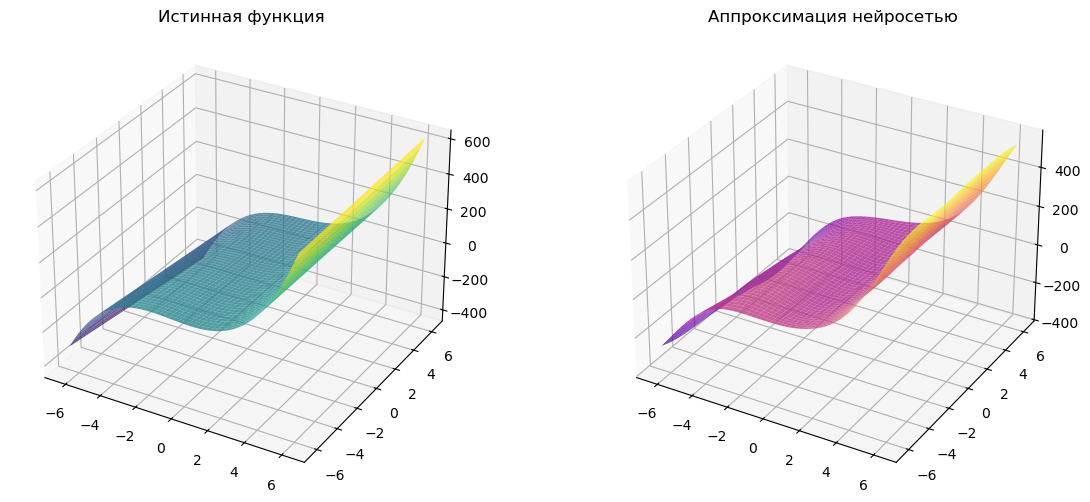

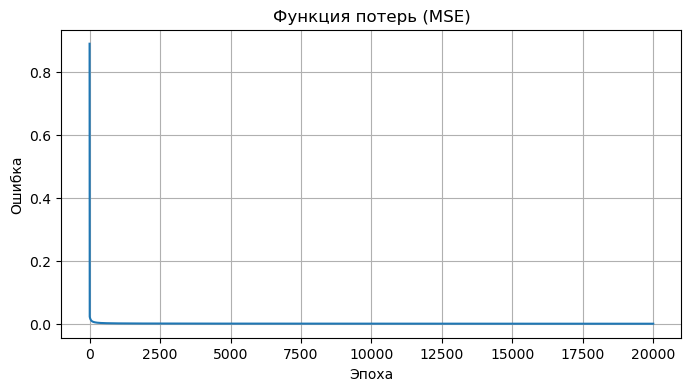


Финальная ошибка (MSE): 375.739288


In [42]:
learning_rate = 0.1
epochs = 20000
yn, y_min, y_max = norm(Y)

W1, b1, W2, b2, losses = train(X, yn, W1, b1, W2, b2, learning_rate, epochs)

with torch.no_grad():
    _, _, _, y_pred = predict(X, W1, b1, W2, b2)
y_pred = denorm(y_pred, y_min, y_max)

Y_pred_plot = y_pred.numpy().reshape(num_points, num_points)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X1, X2, Y_true, cmap='viridis', alpha=0.8)
ax1.set_title("Истинная функция")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(X1, X2, Y_pred_plot, cmap='plasma', alpha=0.8)
ax2.set_title("Аппроксимация нейросетью")

plt.show()

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title("Функция потерь (MSE)")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.grid(True)
plt.show()

final_loss = compute_loss(y_pred, Y)
print(f"\nФинальная ошибка (MSE): {final_loss.item():.6f}") 